<a href="https://colab.research.google.com/github/mitesh98/Amazon-Fine-Food-Review/blob/master/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews Analysis
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 - Oct 2012

Number of Attributes/Columns in data: 10

Attribute Information:

Id

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review

Text - text of the review

Objective: Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

import tqdm

In [0]:
import sqlite3

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/database.sqlite" "database.sqlite"

# Reading Data

In [0]:
con=sqlite3.connect("database.sqlite")

In [8]:
filtered_data=pd.read_sql_query("SELECT * FROM `Reviews` WHERE `Score` !=3",con)
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

In [10]:
actual_score=filtered_data['Score']
posnegative=actual_score.map(partition)
filtered_data['Score']=posnegative
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Exploratory Data Analysis
# 2.1 Data Cleaning: Deduplication
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.

In [11]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True)
sorted_data.shape

(525814, 10)

In [12]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)
final.shape

(364173, 10)

**Observation:- **bold text**  **  It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [14]:
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

# 3. Preprocessing
In the Preprocessing phase we do the following in the order below:-

1.Begin by removing the linksand html tags

2.Expand English language contractions and Remove any punctuations or limited set of special characters like , or . or # etc.

3.Check if the word is made up of english letters and is not alpha-numeric

4.Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)

5.Convert the word to lowercase

6.Remove Stopwords

7.Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

In [15]:
#print(link)
for i in range(0,1000):
  links=re.findall(r'http\S+',final['Text'].values[i])
  for link in links:
    print(link)

http://www.amazon.com/gp/product/B0002DGRSY">Pro-Treat
http://www.amazon.com/gp/product/B0019O5Z0Q">Charlee
http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br
http://www.amazon.com/gp/product/B0088EDMMS">Hocus
http://www.amazon.com/gp/product/B001AGXEAG">Beetlejuice
http://www.amazon.com/gp/product/B001AGXEAG">here</a>.
http://www.amazon.com/gp/product/B001AGXEA6">here</a>.
http://www.amazon.com/gp/product/0790700506">Gremlins</a><br
http://www.amazon.com/gp/product/6301871952">Gremlins
http://www.amazon.com/gp/product/6303347657">Mask</a><br
http://www.amazon.com/gp/product/6304826141">Rocketman</a><br
http://www.amazon.com/gp/product/B001B504LI">The
http://www.amazon.com/gp/product/B001AGXEA6">Beetlejuice
http://www.amazon.com/gp/product/B00004RAMX">Victor
http://www.amazon.com/gp/product/B00004RAMY">Victor
http://www.amazon.com/gp/product/B00004RAMY">Victor
http://www.amazon.com/gp/product/B001VJ3FP6">SentryHOME
http://www.amazon.com/gp/product/B0051GCTAW">Fiprogua

In [0]:
for i in range(0,364171):
  final['Text'].values[i] = re.sub(r"http\S+", "", final['Text'].values[i])

In [0]:
#Remove HTML tags
from bs4 import BeautifulSoup
for i in range(1,364171):
  soup = BeautifulSoup(final['Text'].values[i],'lxml')
  text = soup.get_text()
  final['Text'].values[i]=text

In [0]:
#Expanding English language contractions
def decontracted(phrase):
  # specific
  phrase = re.sub(r"won\'t", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


In [0]:
for i in range(0,364171):
  #print(final['Text'].values[i])
  final['Text'].values[i]=decontracted(final['Text'].values[i])
  #print(final['Text'].values[i])

In [0]:
#remove words with numbers python
for i in range(1,364171):
  #print(final['Text'].values[i])
  final['Text'].values[i] = re.sub("\S*\d\S*", "", final['Text'].values[i]).strip()
  #print(final['Text'].values[i])

In [0]:
#remove spacial character:
for i in range(1,364171):
  final['Text'].values[i]= re.sub('[^A-Za-z0-9]+', ' ', final['Text'].values[i])


In [0]:
#Remove punctution
for i in range(1,364171):
  final['Text'].values[i]= re.sub(r'[!|#|$\%|&|*|?|,|.|\'|/|"|)|(]',r'', final['Text'].values[i])

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
#tqdm
#Instantly make your loops show a smart progress meter
# just wrap any iterable with tqdm(iterable), and you’re done!
from tqdm import tqdm
preprocessed_reviews = []
for i in tqdm(range(0,364171)):
  sentence=""
  #print(final['Text'].values[i])
  for word in final['Text'].values[i].split():
    #print(word)
    word =word.lower()
    if word not in stopwords:
      sentence+=" "+word
  #print(sentence)
  preprocessed_reviews.append(sentence.strip())

100%|██████████| 364171/364171 [00:15<00:00, 23440.20it/s]


In [25]:
preprocessed_reviews[364170]

'purchased send son away college delivered right dorm room fast shipping loved much called thank sadly hardly ever calls anymore want kids call home good snack get midterms send'

In [26]:
final['Cleaned_text']=preprocessed_reviews
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud. recite...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version",I grew up reading these Sendak books and watch...,grew reading sendak books watching really rosi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud it h...,great little book read aloud nice rhythm well ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


In [0]:
#Randomly sample Data 60k points
random_sample_data = final.sample(n=100000) 

In [0]:
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)

**Time Dependence Data Splitting **

In [0]:
y_Train=final_sorted_time['Score'][0:70000]
y_train=final_sorted_time['Score'][0:49000]
y_cv=final_sorted_time['Score'][49000:70000]
y_test=final_sorted_time['Score'][70000:100000]

In [30]:
y_train.value_counts()

1    42101
0     6899
Name: Score, dtype: int64

In [31]:
y_Train.value_counts()

1    59459
0    10541
Name: Score, dtype: int64

In [0]:
Train_data=final_sorted_time['Cleaned_text'][0:70000]
train_data=final_sorted_time['Cleaned_text'][0:49000]
cv_data=final_sorted_time['Cleaned_text'][49000:70000]
test_data=final_sorted_time['Cleaned_text'][70000:100000]

# **Bag Of Words**

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [0]:
from sklearn.metrics import roc_curve, auc

In [0]:
count_vector=CountVectorizer()
train_bows=count_vector.fit_transform(train_data)
cv_bows=count_vector.transform(cv_data)

**Grid Search for optimal HyperParameter**

In [0]:
#tuned_parameter=[{'C':[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]}]
#model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = 'f1', cv=5)
#model.fit(X_train, y_train)
#model=GridSearchCV(LogisticRegression(),tuned_parameter,scoring='roc_auc',cv=5)
#tqdm(model.fit(train_bows,y_train))

Grid Search Cross Validation Taking too much time

**Simple Cross Validation**

In [0]:
clf = LogisticRegression(C=0.01, penalty='l2',class_weight={0: 0.6,1:0.2}) 

In [0]:
import math

In [0]:
AUC_training=[]
AUC_cv=[]
C=[]
c=0.0001
while(c<100000):
  C.append(math.ceil(math.log(c,10)))
  clf = LogisticRegression(C=c, penalty='l2',class_weight={0: 0.6,1:0.4}) #Default penalty=l2
  clf.fit(train_bows, y_train)
  
   #Training Curve
  y_predict_training=clf.predict(train_bows)
  fpr, tpr, thresholds = roc_curve(y_predict_training, y_train)
  AUC_training.append(metrics.auc(fpr, tpr))
  
  #CV Curve
  y_predict_cv=clf.predict(cv_bows)
  fpr, tpr, thresholds = roc_curve(y_predict_cv, y_cv)
  AUC_cv.append(metrics.auc(fpr, tpr))
  c*=10
  

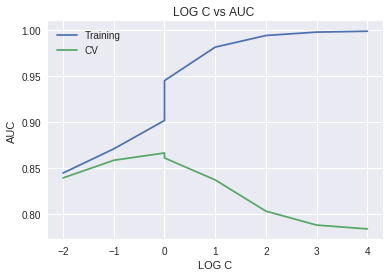

In [39]:
plt.plot(C,AUC_training,label='Training')
plt.plot(C,AUC_cv,label="CV")
plt.ylabel('AUC')
plt.xlabel('LOG C')
plt.title('LOG C vs AUC ')
plt.legend()
plt.show()

**Observation:** C=1 is optimal hyperparmeter having AUC=0.87 with class_weight={0: 0.6,1:0.4}

**Simple Cross Validation with model without class weight**

In [0]:
AUC_training=[]
AUC_cv=[]
C=[]
c=0.0001
while(c<100000):
  C.append(math.ceil(math.log(c,10)))
  clf = LogisticRegression(C=c, penalty='l2') #Default penalty=l2
  clf.fit(train_bows, y_train)
  
   #Training Curve
  y_predict_training=clf.predict(train_bows)
  fpr, tpr, thresholds = roc_curve(y_predict_training, y_train)
  AUC_training.append(metrics.auc(fpr, tpr))
  
  #CV Curve
  y_predict_cv=clf.predict(cv_bows)
  fpr, tpr, thresholds = roc_curve(y_predict_cv, y_cv)
  AUC_cv.append(metrics.auc(fpr, tpr))
  c*=10
  

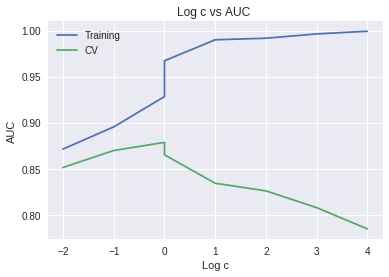

In [41]:
plt.plot(C,AUC_training,label='Training')
plt.plot(C,AUC_cv,label="CV")
plt.ylabel('AUC')
plt.xlabel('Log c')
plt.title('Log c vs AUC ')
plt.legend()
plt.show()

**Observation**: C=1 is optimal hyperparmeter having AUC=0.88 without class_weight

In [42]:
clf.get_params()

{'C': 10000.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [0]:
#For Optimal on test data
count_vectorizer=CountVectorizer()
Train_bows=count_vectorizer.fit_transform(Train_data)
test_bows=count_vectorizer.transform(test_data)


 AUC =  0.8654517410143953


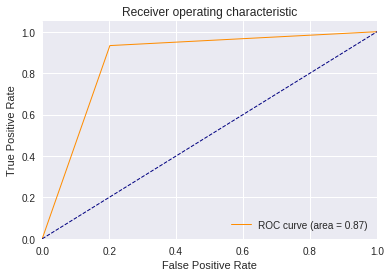




              precision    recall  f1-score   support

           0       0.80      0.68      0.73      5292
           1       0.93      0.96      0.95     24708

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.87      0.82      0.84     30000
weighted avg       0.91      0.91      0.91     30000



In [44]:
clf = LogisticRegression(C=1, penalty='l2') 
clf.fit(Train_bows,y_Train)
y_pred=clf.predict(test_bows)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test,y_pred))

In [45]:
#Checking Sparsity
w=clf.coef_
print(np.count_nonzero(w))
w.shape

50721


(1, 50721)

## Pertubation

In [50]:
count_vectorizer_dash=CountVectorizer()
Train_bows_dash=count_vectorizer_dash.fit_transform(Train_data)
Train_bows_dash.shape

(70000, 50721)

In [0]:
mu=0.1
sigma=0
size=50721
s = np.random.normal(mu, sigma,size)



In [0]:
for x in Train_bows_dash:
  x=x+s

In [53]:
clf_dash = LogisticRegression(C=1, penalty='l2') 
clf_dash.fit(Train_bows_dash,y_Train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
w_dash=clf.coef_

In [0]:
w_dash = w_dash+10**-6

In [0]:
percentage_change_vector = ((w-w_dash)/w )*100

In [0]:
percentage_change_vector[0].shape
#print(percentage_change_vector.max)
l=50720

In [99]:
print (np.percentile(percentage_change_vector,0))
print (np.percentile(percentage_change_vector,10))

-529187.0987371551
-1.0694211646983915


In [100]:
percentage_change_vector[0][25000]
print(percentage_change_vector[0][0])
percentage_change_vector[0][50720]

-0.0001991068279870264


-659.5896805001869

In [0]:
change=[]
percentile=[]
per=0
while(per<=100):
  percentile.append(per)
  change.append(np.percentile(percentage_change_vector,per))
  per+=10

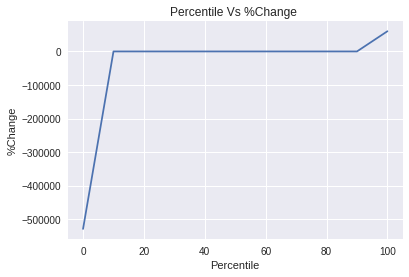

In [104]:
plt.plot(percentile,change)
plt.xlabel('Percentile')
plt.ylabel('%Change')
plt.title('Percentile Vs %Change ')
plt.show()

In [0]:
change=[]
percentile=[]
per=90
while(per<=100):
  percentile.append(per)
  change.append(np.percentile(percentage_change_vector,per))
  per+=1

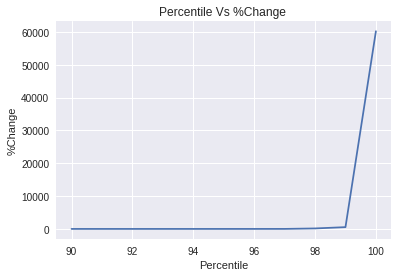

In [106]:
plt.plot(percentile,change)
plt.xlabel('Percentile')
plt.ylabel('%Change')
plt.title('Percentile Vs %Change ')
plt.show()

In [0]:
change=[]
percentile=[]
per=99
while(per<=100):
  percentile.append(per)
  change.append(np.percentile(percentage_change_vector,per))
  per+=0.1

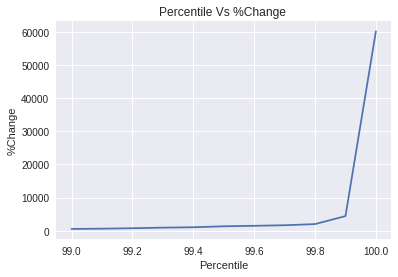

In [108]:
plt.plot(percentile,change)
plt.xlabel('Percentile')
plt.ylabel('%Change')
plt.title('Percentile Vs %Change ')
plt.show()

In [0]:
change=[]
percentile=[]
per=99.8
while(per<=100):
  percentile.append(per)
  change.append(np.percentile(percentage_change_vector,per))
  per+=0.01

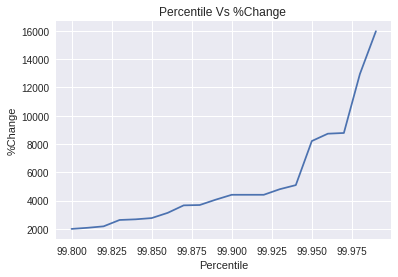

In [110]:
plt.plot(percentile,change)
plt.xlabel('Percentile')
plt.ylabel('%Change')
plt.title('Percentile Vs %Change ')
plt.show()

**Observation:** 99.8 th percentile has sudden increase in %change in their weight.Hence threshold value is 2000

In [114]:
feature_names=count_vector.get_feature_names()
w=clf.coef_
collinear=zip(percentage_change_vector[0],feature_names)
collinear=list(collinear)
collinear.sort(reverse=True,key=lambda x:x[0])
i=0
change=collinear[i][0]
print('%Change\tFeature Name')
while(change>2000):
  print('%.2f\t'%collinear[i][0],collinear[i][1])
  i+=1
  change=collinear[i][0]


%Change	Feature Name
60224.49	 diaphragm
19650.57	 neighbourhood
18041.97	 bethiner
18041.97	 unsuspecting
16139.58	 bifidobacgterium
13854.21	 outgrow
13738.79	 additonal
13738.79	 spokes
12922.84	 beautician
11175.52	 expecially
8791.48	 felafels
8781.06	 areal
8781.06	 eucharist
8781.06	 forexotic
8781.06	 viral
8608.73	 vian
8211.88	 jonesing
8211.88	 mucked
8211.88	 naomi
8211.88	 penutbutter
7879.81	 refreshment
5450.41	 peet
5157.64	 workhorse
5012.39	 delish
5012.39	 paul
4859.66	 conesville
4806.42	 marjoram
4806.42	 redesigned
4475.60	 glossier
4475.60	 grownup
4411.37	 benji
4411.37	 exhausting
4411.37	 grandcat
4411.37	 grandchild
4411.37	 handeling
4411.37	 horseradishdark
4411.37	 iew
4411.37	 importance
4411.37	 importers
4411.37	 mannheim
4411.37	 switched
4411.37	 unfettered
4193.66	 sew
4034.89	 salami
3939.51	 screeching
3858.68	 deb
3744.21	 subjecting
3678.09	 confetti
3663.63	 ane
3663.63	 astonished
3663.63	 gem
3663.63	 indifference
3663.63	 indigenous
3663.63	 

**Top Important Positive Feature**

In [115]:
feature_names=count_vector.get_feature_names()
w=clf.coef_
top=zip(w[0],feature_names)
top=list(top)
top.sort(reverse=True,key=lambda x:x[0])
l=len(top[0])
print('Weight\t\tTop Positive Feature')
for i in range (1,20):
  print("%.2f\t\t"%top[i][0],top[i][1])

Weight		Top Positive Feature
2.58		 lechithin
2.33		 verities
1.96		 supposed
1.94		 gastric
1.93		 biting
1.89		 shicken
1.82		 earliest
1.79		 fanfreakintastic
1.76		 schar
1.74		 earthy
1.72		 lackof
1.69		 orbit
1.64		 transit
1.58		 andevery
1.58		 jamican
1.57		 jo
1.55		 justifiably
1.55		 adjusted
1.50		 excess


**Top Important Negative Feature**

In [116]:
feature_names=count_vector.get_feature_names()
w=clf.coef_
top=zip(w[0],feature_names)
top=list(top)
top.sort(key=lambda x:x[0])
l=len(top[0])
print('Weight\t\tTop Positive Feature')
for i in range (1,20):
  print("%.2f\t\t"%top[i][0],top[i][1])

Weight		Top Positive Feature
-2.43		 escondido
-2.35		 eschew
-2.32		 battled
-2.24		 lemonaid
-2.22		 leeson
-2.05		 euthanized
-2.00		 englanders
-2.00		 teawas
-1.94		 brevity
-1.92		 cyanogenic
-1.92		 nelly
-1.92		 pomrerain
-1.86		 hall
-1.84		 pthey
-1.82		 eightish
-1.80		 pemproke
-1.76		 teazonline
-1.74		 chemo
-1.74		 teavana


**Linear Regression Model with L1 Regularization**

 AUC =  0.8654670489483345


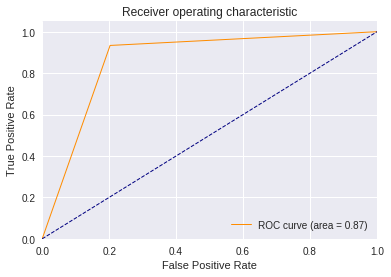




              precision    recall  f1-score   support

           0       0.80      0.68      0.73      5292
           1       0.93      0.96      0.95     24708

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.87      0.82      0.84     30000
weighted avg       0.91      0.91      0.91     30000



In [117]:
clf=LogisticRegression(C=1,penalty='l1')
clf.fit(Train_bows,y_Train)
y_pred=clf.predict(test_bows)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test,y_pred))

**Checking Sparsity with L1 Regularization**

In [118]:
w=clf.coef_
print(np.count_nonzero(w))



4948


**Observation:**

1.No of Nonzero weights in L2 Regularization is 50527

2.No of Nonzero weights in L1 Regularization is 4936

Huge increase in sparsity

In [119]:
# More Sparsity (Fewer elements of W* being non-zero) by increasing Lambda (decreasing C) 
Nonzero=[]
C=[]
c=0.001
print('C\t\tNumber of Nonzero Weights')
while(c<1000):
  C.append(math.ceil(math.log(c,10)))
  clf=LogisticRegression(C=c,penalty='l1')
  clf.fit(Train_bows,y_Train)
  w=clf.coef_
  Nonzero.append(np.count_nonzero(w))
  print(c,'\t\t',np.count_nonzero(w))
  c*=10

C		Number of Nonzero Weights
0.001 		 6
0.01 		 129
0.1 		 938
1.0 		 4945
10.0 		 10583
100.0 		 12715


No handles with labels found to put in legend.


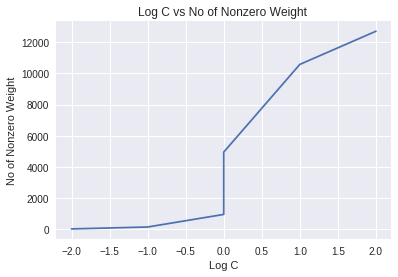

In [120]:
plt.plot(C,Nonzero)
plt.ylabel('No of Nonzero Weight')
plt.xlabel('Log C')
plt.title('Log C vs No of Nonzero Weight ')
plt.legend()
plt.show()

# TFIDF

In [0]:
tfidf_vector=TfidfVectorizer()
train_tfidf=tfidf_vector.fit_transform(train_data)
cv_tfidf=tfidf_vector.transform(cv_data)

**Simple Cross Validation**

In [0]:
AUC_training=[]
AUC_cv=[]
C=[]
c=-3
while(c<4):
  C.append(c)
  clf = LogisticRegression(C=10**c, penalty='l2') #Default penalty=l2
  clf.fit(train_tfidf, y_train)
  
   #Training Curve
  y_predict_training=clf.predict(train_tfidf)
  fpr, tpr, thresholds = roc_curve(y_predict_training, y_train)
  AUC_training.append(metrics.auc(fpr, tpr))
  
  #CV Curve
  y_predict_cv=clf.predict(cv_tfidf)
  fpr, tpr, thresholds = roc_curve(y_predict_cv, y_cv)
  AUC_cv.append(metrics.auc(fpr, tpr))
  c+=1
  

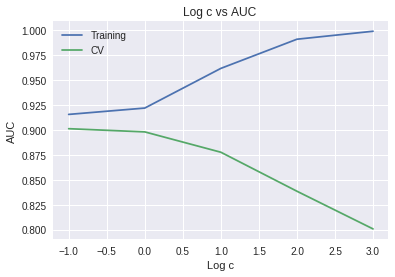

In [126]:
plt.plot(C,AUC_training,label='Training')
plt.plot(C,AUC_cv,label="CV")
plt.ylabel('AUC')
plt.xlabel('Log c')
plt.title('Log c vs AUC ')
plt.legend()
plt.show()

**Observation:** C=1 is optimal hyperparmeter having AUC=0.90 without class_weight

In [0]:
#For Optimal on test data
tfidf_vector=TfidfVectorizer()
Train_tfidf=tfidf_vector.fit_transform(Train_data)
test_tfidf=tfidf_vector.transform(test_data)

 AUC =  0.8895992593962324


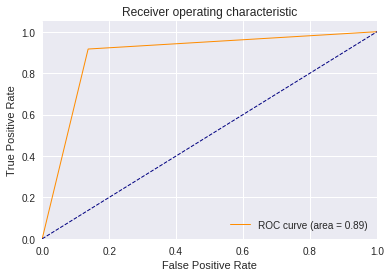




              precision    recall  f1-score   support

           0       0.86      0.58      0.70      5292
           1       0.92      0.98      0.95     24708

   micro avg       0.91      0.91      0.91     30000
   macro avg       0.89      0.78      0.82     30000
weighted avg       0.91      0.91      0.90     30000



In [128]:
clf = LogisticRegression(C=1, penalty='l2') 
clf.fit(Train_tfidf,y_Train)
y_pred=clf.predict(test_tfidf)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test,y_pred))

**Top Positive Features**

In [130]:
feature_names=tfidf_vector.get_feature_names()
w=clf.coef_
top=zip(w[0],feature_names)
top=list(top)
top.sort(reverse=True,key=lambda x:x[0])
l=len(top[0])
print('Weight\t\tTop Positive Feature')
for i in range (1,20):
  print("%.2f\t\t"%top[i][0],top[i][1])

Weight		Top Positive Feature
8.66		 best
8.05		 delicious
7.17		 perfect
7.15		 good
6.55		 excellent
6.47		 loves
6.39		 love
5.72		 highly
5.60		 wonderful
5.20		 nice
5.05		 favorite
4.60		 pleased
4.55		 amazing
4.54		 tasty
4.50		 happy
4.49		 easy
4.27		 yummy
4.24		 smooth
4.22		 definitely


**Top Negative Features**

In [132]:
feature_names=tfidf_vector.get_feature_names()
w=clf.coef_
top=zip(w[0],feature_names)
top=list(top)
top.sort(key=lambda x:x[0])
l=len(top[0])
print('Weight\t\tTop Negative Feature')
for i in range (1,20):
  print("%.2f\t\t"%top[i][0],top[i][1])

Weight		Top Negative Feature
-7.80		 worst
-6.36		 disappointed
-6.35		 awful
-6.20		 terrible
-6.12		 horrible
-5.85		 disappointing
-5.57		 disappointment
-5.52		 bland
-5.47		 threw
-5.16		 unfortunately
-5.10		 return
-4.60		 tasteless
-4.51		 disgusting
-4.37		 hoping
-4.37		 waste
-4.34		 worse
-4.33		 money
-4.26		 stale
-3.92		 sorry


# Word2Vec

In [0]:
#Train own W2V with train data
i=0
list_of_sentence=[]
for sent in train_data.values:
  list_of_sentence.append(sent.split())

In [0]:
w2v_model=gensim.models.Word2Vec(list_of_sentence,min_count=5,size=50,workers=4)

In [0]:
w2v_words = list(w2v_model.wv.vocab)

In [181]:
# Average W2V with training Data
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
#print(sent_vectors)
print(len(sent_vectors[0]))

49000
50


In [180]:
sent_vectors[49]

array([-0.03635443, -0.20117255,  0.28932798,  0.12100915, -1.29773333,
       -0.14045732,  0.38774436,  0.01730783,  0.25027181,  0.99703476,
       -0.14590456,  0.46319224, -0.13865868,  0.41011202, -0.49298705,
       -0.48523868, -0.16020769,  0.0524766 , -0.15539374, -0.27439437,
       -1.21323375,  0.0731979 ,  0.28794207,  0.01360976,  0.17986842,
       -0.45636012, -0.27563123, -0.77005464, -0.20762008,  0.12917916,
        0.15112045, -0.23642529, -0.02588361, -0.13747826, -0.41617008,
       -0.24458788, -0.02496167,  0.26504465,  0.51069165,  0.02348844,
        0.03542238,  0.18670231,  0.25767448,  0.19802293, -0.41889921,
       -0.23788456,  0.42469777, -0.35686992,  0.1083397 ,  0.25322425])

In [0]:
#Train own W2V with cv data
i=0
list_of_sentence_cv=[]
for sent in cv_data.values:
  list_of_sentence_cv.append(sent.split())

In [0]:
w2v_model_cv=gensim.models.Word2Vec(list_of_sentence_cv,min_count=5,size=50,workers=4)

In [0]:
w2v_words_cv = list(w2v_model_cv.wv.vocab)

In [188]:
# Average W2V with cv Data
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_cv: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_cv:
            vec = w2v_model_cv.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
#print(sent_vectors)
print(len(sent_vectors_cv[0]))

21000
50


**Simple Cross Validation**

In [192]:
y_train.shape

(49000,)

In [0]:
AUC_training=[]
AUC_cv=[]
C=[]
c=-3
while(c<4):
  C.append(c)
  clf = LogisticRegression(C=10**c, penalty='l2') #Default penalty=l2
  clf.fit(sent_vectors, y_train)
  
   #Training Curve
  y_predict_training=clf.predict(sent_vectors)
  fpr, tpr, thresholds = roc_curve(y_predict_training, y_train)
  AUC_training.append(metrics.auc(fpr, tpr))
  
  #CV Curve
  y_predict_cv=clf.predict(sent_vectors_cv)
  fpr, tpr, thresholds = roc_curve(y_predict_cv, y_cv)
  AUC_cv.append(metrics.auc(fpr, tpr))
  c+=1

In [194]:
AUC_training

[0.8441160437701973,
 0.8147751935954463,
 0.8060927823809658,
 0.8046791717851987,
 0.8044920500861514,
 0.8044520183210622,
 0.8044520183210622]

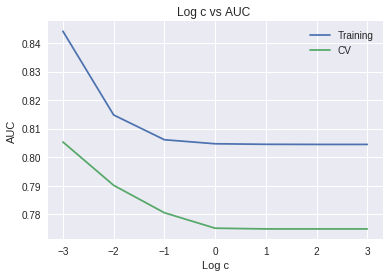

In [195]:
plt.plot(C,AUC_training,label='Training')
plt.plot(C,AUC_cv,label="CV")
plt.ylabel('AUC')
plt.xlabel('Log c')
plt.title('Log c vs AUC ')
plt.legend()
plt.show()

**Observation:** Optimal Value of C=10^-3 having AUC score 0.805

**Avg W2V for test data**

In [0]:
#Train own W2V with cv data
i=0
list_of_sentence_test=[]
for sent in test_data.values:
  list_of_sentence_test.append(sent.split())

In [0]:
w2v_model_test=gensim.models.Word2Vec(list_of_sentence_test,min_count=5,size=50,workers=4)

In [0]:
w2v_words_test = list(w2v_model_test.wv.vocab)

In [199]:
# Average W2V with test Data
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentence_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            #print("vec= ",vec)
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
#print(sent_vectors)
print(len(sent_vectors_test[0]))


30000
50


 AUC =  0.7727290708468711


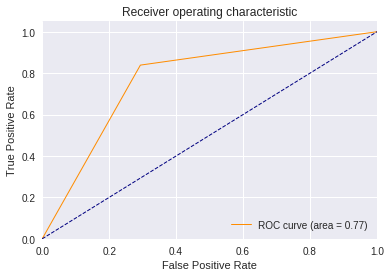




              precision    recall  f1-score   support

           0       0.71      0.11      0.19      5292
           1       0.84      0.99      0.91     24708

   micro avg       0.84      0.84      0.84     30000
   macro avg       0.77      0.55      0.55     30000
weighted avg       0.82      0.84      0.78     30000



In [201]:
clf = LogisticRegression(C=0.001, penalty='l2') 
clf.fit(sent_vectors,y_train)
y_pred=clf.predict(sent_vectors_test)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test,y_pred))

# TF_IDF Avg W2V

In [0]:
#TF-IDF Avg W2V for train Data
model_train = TfidfVectorizer()
tf_idf_matrix_train = model_train.fit_transform(train_data)
dictionary = dict(zip(model_train.get_feature_names(), list(model.idf_)))

In [0]:
tfidf_feat_train = model_train.get_feature_names() 

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent: 
    try:
      vec = w2v_model.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_train.append(sent_vec)
  row += 1

In [0]:
#TF-IDF Avg W2V for cv Data
model_cv = TfidfVectorizer()
tf_idf_matrix_cv = model_cv.fit_transform(cv_data)
dictionary = dict(zip(model_cv.get_feature_names(), list(model.idf_)))

In [0]:
tfidf_feat_cv = model_cv.get_feature_names() 

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_cv: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_cv.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_cv.append(sent_vec)
  row += 1

**Simple Cross Validation**

In [0]:
AUC_training=[]
AUC_cv=[]
C=[]
c=-3
while(c<4):
  C.append(c)
  clf = LogisticRegression(C=10**c, penalty='l2') #Default penalty=l2
  clf.fit(tfidf_sent_vectors_train, y_train)
  
   #Training Curve
  y_predict_training=clf.predict(tfidf_sent_vectors_train)
  fpr, tpr, thresholds = roc_curve(y_predict_training, y_train)
  AUC_training.append(metrics.auc(fpr, tpr))
  
  #CV Curve
  y_predict_cv=clf.predict(tfidf_sent_vectors_cv)
  fpr, tpr, thresholds = roc_curve(y_predict_cv, y_cv)
  AUC_cv.append(metrics.auc(fpr, tpr))
  c+=1

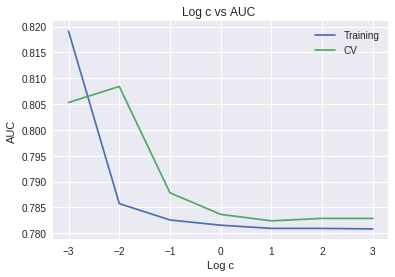

In [223]:
plt.plot(C,AUC_training,label='Training')
plt.plot(C,AUC_cv,label="CV")
plt.ylabel('AUC')
plt.xlabel('Log c')
plt.title('Log c vs AUC ')
plt.legend()
plt.show()

**Observation:** Optimal value of C=0.01 having AUC score =0.807

In [0]:
#TF-IDF Avg W2V for test Data
model_test = TfidfVectorizer()
tf_idf_matrix_test = model_test.fit_transform(test_data)
dictionary = dict(zip(model_test.get_feature_names(), list(model.idf_)))

In [0]:
tfidf_feat_test = model_test.get_feature_names() 

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentence_test: 
  sent_vec = np.zeros(50) 
  weight_sum =0; 
  for word in sent:
    try:
      vec = w2v_model_test.wv[word]
      tf_idf = dictionary[word]*(sent.count(word)/len(sent))
      sent_vec += (vec * tf_idf)
      weight_sum += tf_idf
    except:
      pass
          
  if weight_sum != 0:
    sent_vec /= weight_sum
  tfidf_sent_vectors_test.append(sent_vec)
  row += 1

 AUC =  0.7041761554009247


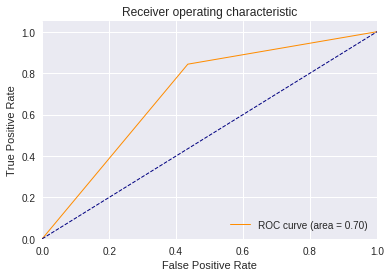




              precision    recall  f1-score   support

           0       0.57      0.15      0.24      5292
           1       0.84      0.97      0.90     24708

   micro avg       0.83      0.83      0.83     30000
   macro avg       0.70      0.56      0.57     30000
weighted avg       0.79      0.83      0.79     30000



In [226]:
clf = LogisticRegression(C=0.01, penalty='l2') 
clf.fit(tfidf_sent_vectors_train,y_train)
y_pred=clf.predict(tfidf_sent_vectors_test)
 #Drawing ROC curve
fpr, tpr, thresholds = roc_curve(y_pred, y_test)
roc_auc = auc(fpr, tpr)
print(' AUC = ',metrics.auc(fpr, tpr))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print("\n\n")
print(metrics.classification_report(y_test,y_pred))